# ASSIGNMENT - 1  

> Cifar-10 Cross validation 

`Name - MD MOSTAFIZUR RAHMAN `

`ID - 20-42594-1 `

```python
Step -1 
     Setup environment 
     Import neccessary libraries 
``` 

In [45]:
import os              #get the image path from folder
import random
import cv2             #for read image
from tqdm import tqdm  #for progress bar 
import numpy as np    
import matplotlib.pyplot as plt

```python
Train folder has 10 folder in itself 
```

- store train folder path in variable
- Then, Store all 10 folder in a list

In [113]:
TRAIN_DIR = 'F:\cvpr\CIFAR-10-images-master/train'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Read the images from folder using CV2 Library 
and stored them in a list 


In [115]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR,c)
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        
        img_arr = cv2.imread(os.path.join(path,img))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 5000/5000 [00:41<00:00, 120.25it/s]

50000


### Now, we randomise our Stored data and show some images below as proofe 

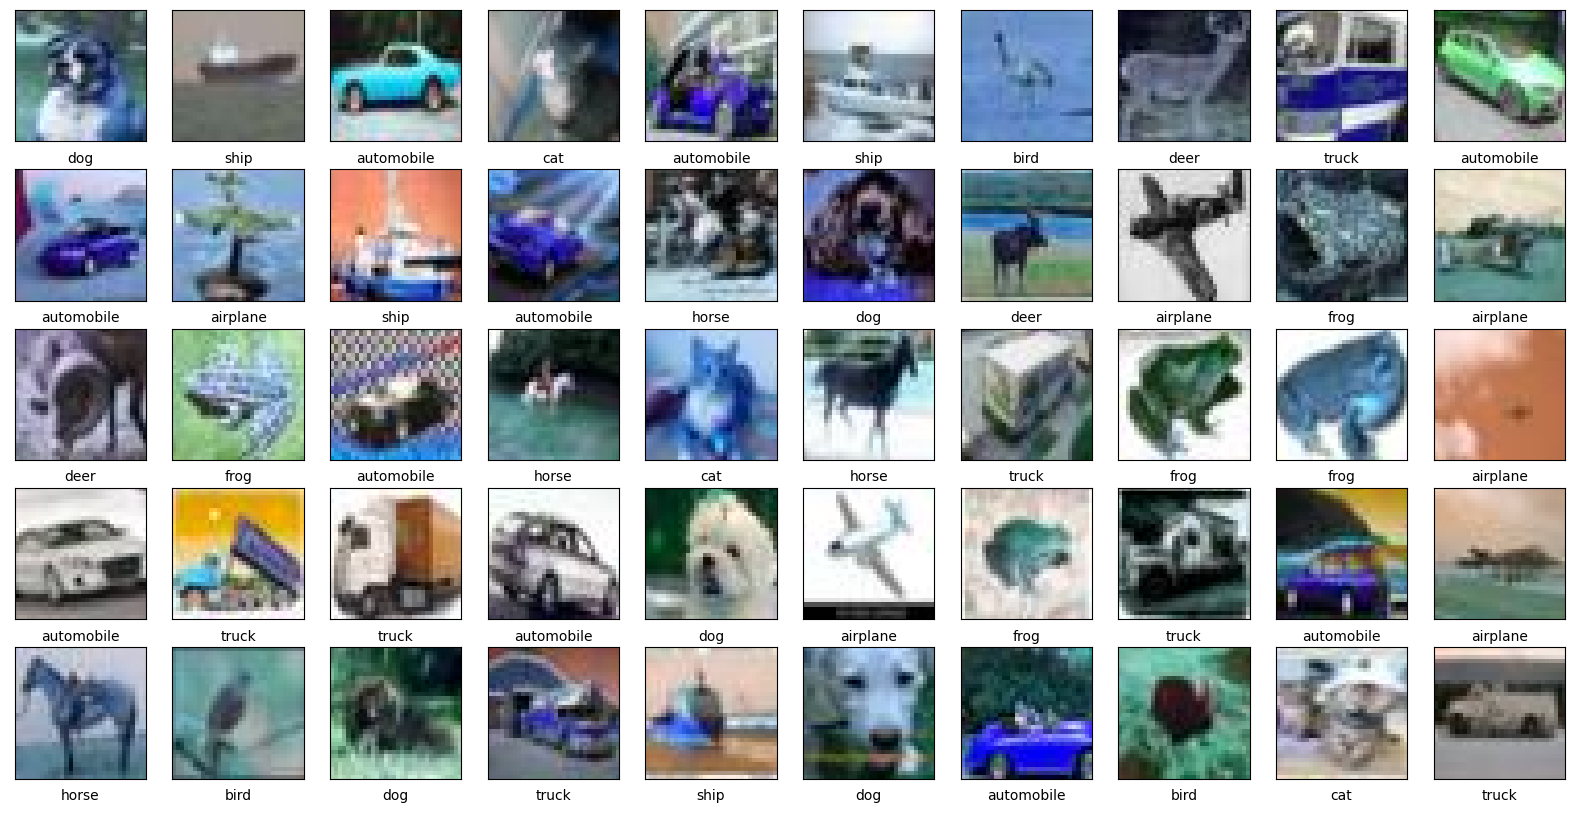

In [48]:
random.shuffle(TRAIN_DATA)

plt.figure(figsize=(20,10))

for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(TRAIN_DATA[i][0])
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()

```python
Here, i have stored randomised data into different 5 fold.
```

In [52]:
f0 = TRAIN_DATA[0:400]
f1 = TRAIN_DATA[400:800]
f2 = TRAIN_DATA[800:1200]
f3 = TRAIN_DATA[1200:1600]
f4 = TRAIN_DATA[1600:2000]
folds = [f0, f1, f2, f3, f4]

#### I have imported two more libraries for calculation distance 

In [53]:
from scipy.spatial.distance import cityblock
import math


```python
First, create distance-calculating functions.
Secondly, Normalize them into a 1D array list.
And at the end, Create two functions that will be used in sorting accuracies. 
```

In [54]:
# Calculate Manhattan Distance (L1)
def manhattan_distance(point1, point2):    
    return cityblock(point1, point2)


# Calculate Euclidian Distance (L2)
def euclidian_distance(point1, point2):    
    return math.dist(point1, point2)


def normalize(data):
    return [[np.round(img_array / 255, 3).flatten(), class_num] for [img_array, class_num] in data]


def by_l1_dist(list):
    return list[2]["l1"]


def by_l2_dist(list):
    return list[2]["l2"]

# Calculation process 

In [55]:
top_filter = 20


def cal_dist(train_fold, valid_fold):

    l1_result = []
    l2_result = []

    for valid in tqdm(valid_fold):  # valid = [img_resized, class_num]
      
        temp_dist_list = []
       
        for train in train_fold:    # train = [img_resized, class_num]

            l1_dist = manhattan_distance(valid[0], train[0])
            l2_dist = euclidian_distance(valid[0], train[0])

            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])

        # sort by L1

        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])

        # sort by L2
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])
        
    return [l1_result, l2_result]


# Using KNN and getting accuracy 

In [89]:
k_range = 20

def cal_accuracy(dist_result, dist_term):
    k_accuracies = [] 
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]  # nn = [[4, 2, {'l1': 148.43, 'l2': 3.4}]]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:  
                if (k/ 2)< same_class_len:  # checking maximum same class
                    img_accuracy += 1
            else:  
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class):
                    same_class_dist = sum([c[2][dist_term] for c in same_class])
                    diff_class_dist = sum([c[2][dist_term] for c in diff_class])
                    if same_class_dist > diff_class_dist: 
                        img_accuracy += 1 
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies


In [90]:
normal_folds = [normalize(data) for data in folds]

```python
> We have 5 folds and calculated all the accuracies according to each fold. 
```

In [75]:
dist_by_fold = []
fold_num_th=0
for fold1 in normal_folds:
    valid_fold = normal_folds[fold_num_th]
    train_fold = sum([fold for j, fold in enumerate(normal_folds) if fold_num_th != j], [])
    dist_by_fold.append(cal_dist(train_fold, valid_fold))
    fold_num_th=fold_num_th+1
    if fold_num_th>= 5: break 

100%|██████████| 400/400 [06:08<00:00,  1.09it/s]


```c++
Storing accuracy in a list with the class of validation image.
```

In [87]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])

### Ploting L1 distance accuracy and L2 distance accuracy 

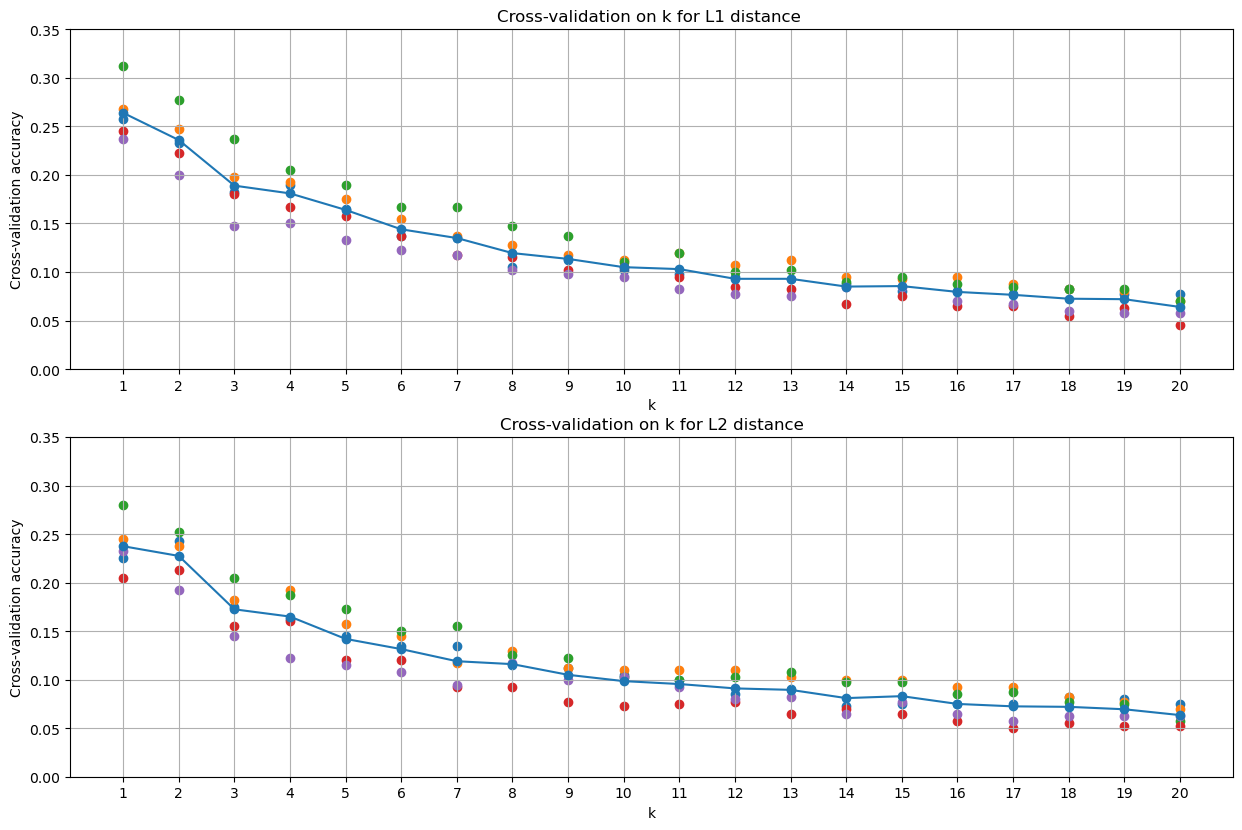

In [111]:
from statistics import mean

x_list = list(range(1,21))
plt.figure(figsize=(15, 15))
plt.subplot(3,1,1)

for fold in accuracies:
  plt.scatter(x_list, fold[0]) # fold[0] = l1_accurracy\

arr = [] 
for i in range(k_range):
  arr.append([b[0][i] for b in accuracies])
trend = [mean(a) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')
plt.title('Cross-validation on k for L1 distance ')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.ylim([0.0, 0.35])
plt.subplot(3,1,2)

for fold in accuracies:
  plt.scatter(x_list, fold[1]) 
arr = [] 
for i in range(k_range):
  arr.append([b[1][i] for b in accuracies])
trend = [mean(a) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')
plt.title('Cross-validation on k for L2 distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.ylim([0.0, 0.35])


plt.show()

# Discussion 

### In this assignment, I have now calculated the accuracy for a random training dataset. I took 2000 images from this dataset and divided them into five folds. I calculate the accuracy of every fold's images against all other folds except the fold itself. Then got the accuracy from every fold and sorted them to the top 20. Here, we have two kinds of accuracy for two different distance calculations in each fold.

*1. Manhattan Distance (L1)*

*2. Euclidian Distance (L2)*

### That's why we have two plots for L1 and L2, respectively. In L1 and L2 distance calculation accuracy plots, we got higher accuracy in k1, but their accuracy values are different. L1's highest accuracy is around 31%, and L2's is 28%. Then, consecutively, mean accuracy decreased when the k-th value increased till the k-17th value. We get a plane line between k-17 & k-18th. Then, slightly decreased the line to k-20th. 
```c++
We get both graphs quite similar, but the l2 curve is more plane than the l1 curve. 
```